# Converter (for EfficientDet)

Welcome to the BWE tflite converter and its metadata populator

In [1]:
# Support for TF2 models was added after TF 2.3.
!pip install tf-nightly

     |████████████████████████████████| 453.4MB 35kB/s 
     |████████████████████████████████| 5.9MB 23.2MB/s 
     |████████████████████████████████| 1.3MB 8.5MB/s 
     |████████████████████████████████| 471kB 30.8MB/s 
     |████████████████████████████████| 4.0MB 35.1MB/s 
     |████████████████████████████████| 4.2MB 31.9MB/s 
     |████████████████████████████████| 4.9MB 31.9MB/s 
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement grpcio~=1.32.0, but you'll have grpcio 1.37.1 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: grpcio 1.32.0
    Uninstalling grpcio-1.32.0:
      Successfully uninstalled grpcio-1.32.0
  Found existing installation: h5py 2.10.0
    Uninstallin

In [2]:
import tensorflow as tf

In [3]:
!unzip saved_model.zip

Archive:  saved_model.zip
   creating: saved_model/
  inflating: saved_model/saved_model.pb  
   creating: saved_model/variables/


In [4]:
!tflite_convert --saved_model_dir=saved_model --output_file=model.tflite

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
I0517 07:02:55.370019 140137847469952 saver.py:1517] Saver not created because there are no variables in the graph to restore
2021-05-17 07:02:55.520690: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-05-17 07:02:55.782984: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2021-05-17 07:02:55.804777: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1765] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to do

# Populator


In [11]:
with open('tflite_label_map.txt', 'w') as f:
    f.write('bonggol\n???')

In [4]:
!pip install tflite_support_nightly

In [12]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

ObjectDetectorWriter = object_detector.MetadataWriter

_MODEL_PATH = "model.tflite"
_SAVE_TO_PATH = "model_with_metadata.tflite"
_LABEL_PATH = "tflite_label_map.txt"

writer = ObjectDetectorWriter.create_for_inference(
    writer_utils.load_file(_MODEL_PATH), input_norm_mean=[0], 
    input_norm_std=[1], label_file_paths=[_LABEL_PATH])
writer_utils.save_file(writer.populate(), _SAVE_TO_PATH)

In [ ]:
from tflite_support import metadata

displayer = metadata.MetadataDisplayer.with_model_file(_SAVE_TO_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("=============================")
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

In [8]:
#@title Load the trained TFLite model and define some visualization functions
import numpy as np
import cv2

from PIL import Image

model_path = 'model_with_metadata.tflite'
label_map_path = 'tflite_label_map.txt'

# Load the labels into a list
with open(label_map_path, 'r') as f:
  classes = f.read().splitlines()

# Define a list of colors for visualization
COLORS = np.random.randint(0, 255, size=(len(classes), 3), dtype=np.uint8)

def preprocess_image(image_path, input_size):
  """Preprocess the input image to feed to the TFLite model"""
  img = tf.io.read_file(image_path)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.uint8)
  original_image = img
  resized_img = tf.image.resize(img, input_size)
  resized_img = resized_img[tf.newaxis, :]
  return resized_img, original_image


def set_input_tensor(interpreter, image):
  """Set the input tensor."""
  tensor_index = interpreter.get_input_details()[0]['index']
  input_tensor = interpreter.tensor(tensor_index)()[0]
  input_tensor[:, :] = image


def get_output_tensor(interpreter, index):
  """Retur the output tensor at the given index."""
  output_details = interpreter.get_output_details()[index]
  tensor = np.squeeze(interpreter.get_tensor(output_details['index']))
  return tensor


def detect_objects(interpreter, image, threshold):
  """Returns a list of detection results, each a dictionary of object info."""
  # Feed the input image to the model
  set_input_tensor(interpreter, image)
  interpreter.invoke()

  # Get all outputs from the model
  boxes = get_output_tensor(interpreter, 0)
  classes = get_output_tensor(interpreter, 1)
  scores = get_output_tensor(interpreter, 2)
  count = int(get_output_tensor(interpreter, 3))

  results = []
  for i in range(count):
    if scores[i] >= threshold:
      result = {
        'bounding_box': boxes[i],
        'class_id': classes[i],
        'score': scores[i]
      }
      results.append(result)
  return results


def run_odt_and_draw_results(image_path, interpreter, threshold=0.5):
  """Run object detection on the input image and draw the detection results"""
  # Load the input shape required by the model
  _, input_height, input_width, _ = interpreter.get_input_details()[0]['shape']

  # Load the input image and preprocess it
  preprocessed_image, original_image = preprocess_image(
      image_path, 
      (input_height, input_width)
    )

  # Run object detection on the input image
  results = detect_objects(interpreter, preprocessed_image, threshold=threshold)

  # Plot the detection results on the input image
  original_image_np = original_image.numpy().astype(np.uint8)
  for obj in results:
    # Convert the object bounding box from relative coordinates to absolute 
    # coordinates based on the original image resolution
    ymin, xmin, ymax, xmax = obj['bounding_box']
    xmin = int(xmin * original_image_np.shape[1])
    xmax = int(xmax * original_image_np.shape[1])
    ymin = int(ymin * original_image_np.shape[0])
    ymax = int(ymax * original_image_np.shape[0])

    # Find the class index of the current object
    class_id = int(obj['class_id'])

    # Draw the bounding box and label on the image
    color = [int(c) for c in COLORS[class_id]]
    cv2.rectangle(original_image_np, (xmin, ymin), (xmax, ymax), color, 2)
    # Make adjustments to make the label visible for all objects
    y = ymin - 15 if ymin - 15 > 15 else ymin + 15
    label = "{}: {:.0f}%".format(classes[class_id], obj['score'] * 100)
    cv2.putText(original_image_np, label, (xmin, y),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

  # Return the final image
  original_uint8 = original_image_np.astype(np.uint8)
  return original_uint8

##Pic Tester
###Bonggol pic test
1. https://storage.googleapis.com/semai_gan/11-2021-04-21T07%3A11%3A28.801Z.JPG
2. https://storage.googleapis.com/semai_gan/13-2021-04-21T07%3A11%3A28.801Z.JPG
3. https://storage.googleapis.com/semai_gan/15-2021-04-21T07%3A11%3A28.801Z.JPG
4. https://storage.googleapis.com/semai_gan/14-2021-04-21T07%3A11%3A28.801Z.JPG

###Rubber duck pic test
1. https://storage.googleapis.com/test-datasets-bwe/out1.jpg

###People pic test
1. https://storage.googleapis.com/test-datasets-bwe/for%20centernet.jpeg

###Brondolan pic test
1. https://storage.googleapis.com/test-datasets-bwe/brondol%20(2).jpeg
2. https://storage.googleapis.com/test-datasets-bwe/brondol%20(3).jpeg
3. https://storage.googleapis.com/test-datasets-bwe/brondol%20(4).jpeg
4. https://storage.googleapis.com/test-datasets-bwe/brondol%20(5).jpeg
5. https://storage.googleapis.com/test-datasets-bwe/brondol%20(6).jpeg
6. https://storage.googleapis.com/test-datasets-bwe/brondol.jpeg

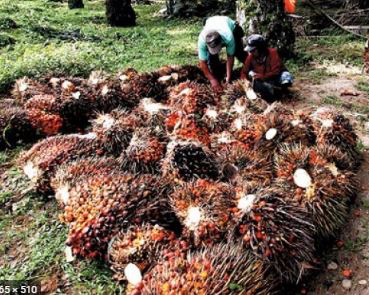

In [10]:
import tensorflow as tf


#@title Run object detection and show the detection results

INPUT_IMAGE_URL = "https://storage.googleapis.com/semai_gan/11-2021-04-21T07%3A11%3A28.801Z.JPG" #@param {type:"string"}
DETECTION_THRESHOLD = 0.3 #@param {type:"number"}

TEMP_FILE = '/tmp/image.png'

!wget -q -O $TEMP_FILE $INPUT_IMAGE_URL
im = Image.open(TEMP_FILE)
im.thumbnail((512, 512), Image.ANTIALIAS)
im.save(TEMP_FILE, 'PNG')

# Load the TFLite model
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

# Run inference and draw detection result on the local copy of the original file
detection_result_image = run_odt_and_draw_results(
    TEMP_FILE, 
    interpreter, 
    threshold=DETECTION_THRESHOLD
)

# Show the detection result
Image.fromarray(detection_result_image)